# Simulation and Statistical Inference

Today, we will cover simulation modeling and statistical inference in Python, using the numpy.random and scipy.stats packages.

Friendly Reminders:

* Project Showcase on Thursday, 5/10 (last day of class)

In [1]:
%pylab inline
import pandas as pd
import scipy.stats as ss

Populating the interactive namespace from numpy and matplotlib


## NumPy and SciPy for Simulation

There are two primary sub-packages that contain functionality for generating observations from probability distributions (*random variates*), which is the foundation for simulation modeling:

* **numpy.random** - Contains many of the most common distributions, along with functionality for controlling the state of the internal random number generator (see https://docs.scipy.org/doc/numpy-1.14.0/reference/routines.random.html for additional details)

* **scipy.stats** - Much larger package that includes a larger library of probability distributions, along with functionality for computing descriptive statistics, performing statistical tests and various other types of statistical analysis (see https://docs.scipy.org/doc/scipy/reference/stats.html for additional details)

The functionality within numpy.random--as we have seen already--is fairly straightforward to use for the purposes of generating random variates.

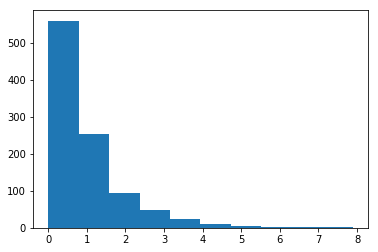

In [2]:
# X ~ Exponential(1)
x = np.random.exponential(scale=1, size=1000)
plt.hist(x);

In scipy.stats, each distribution is an instance of a class that contains a lot of methods for working with probability distributions, such as:

* .rvs - method for generating random variates from the distribution
* .pdf - method for calculating probability density function values ($f(x)$)
* .cdf - method for calculating cumulative density function values ($F(x)$)
* .ppf - method for calculating quantile values from the cumulative density function
* .fit - method for estimating the best distributional parameters to fit a given sample of data

as well as functions for computing specific statistics for the paramaterized distribution (e.g., .mean, .median, .var, .std). 

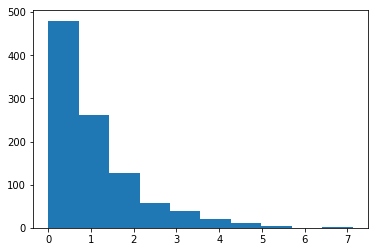

In [3]:
# X ~ Exponential(1)
x = ss.expon.rvs(loc=0, scale=1, size=1000)
plt.hist(x);

In [4]:
# Fit distribution
print('The best fit parameters for the exponential distribution are loc=%.4f and scale=%.4f.' % ss.expon.fit(x))

The best fit parameters for the exponential distribution are loc=0.0013 and scale=1.0778.


We will now explore an example of how these tools could be used to support decision making in a simulation scenario.

## D.C. Housing

Mr. Grand Diggs wants to build and sell a house on a plot of land he owns.

**Key Challenge** - Real estate market is volatile:

* Uncertainty in construction costs
* Uncertainty in time to sell
* Uncertainty in selling price

**Goal**: Use simulation to help Mr. Diggs determine what size house to build in order to maximize his expected profit.

In [5]:
# Define number of replications
N = 1000

In [6]:
# Specify square footage of house
sqft = 2500

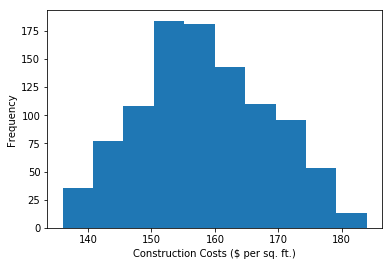

In [7]:
# Construction costs per square foot ~ Triangular(135, 155, 185) dollars per square foot
costs_sqft = np.random.triangular(left=135, mode=155, right=185, size=N)
plt.hist(costs_sqft)
plt.xlabel('Construction Costs (\$ per sq. ft.)')
plt.ylabel('Frequency');

In [8]:
# Total construction costs
costs = sqft * costs_sqft

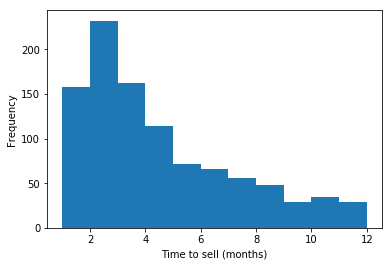

In [9]:
# Time to sell ~ Discrete distribution
months = range(1, 13)
p = [0.16, 0.22, 0.18, 0.11, 0.08, 0.06, 0.05, 0.05, 0.03, 0.03, 0.02, 0.01]
t = np.random.choice(a=months, p=p, size=N)
plt.hist(t, bins=months)
plt.xlabel('Time to sell (months)')
plt.ylabel('Frequency');

In [10]:
# Initial asking price per square foot
initial_asking_sqft = 280 - 0.02 * sqft
initial_asking_sqft

230.0

In [11]:
# Initial asking price
initial_asking = sqft * initial_asking_sqft
initial_asking

575000.0

In [12]:
# Initial asking price at time of sale
pct_reduction = 0.01 # per month
initial_offer = initial_asking * (1 - t * pct_reduction)

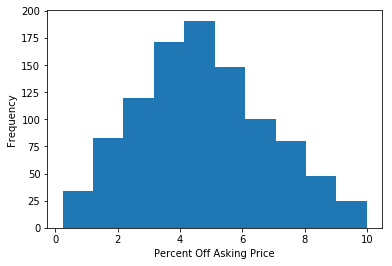

In [13]:
# Negotations
pct_off_asking = np.random.triangular(left=0., mode=0.04, right=0.10, size=N)
plt.hist(100 * pct_off_asking)
plt.xlabel('Percent Off Asking Price')
plt.ylabel('Frequency');

In [14]:
# Final Sale
sales = initial_offer * (1 - pct_off_asking)

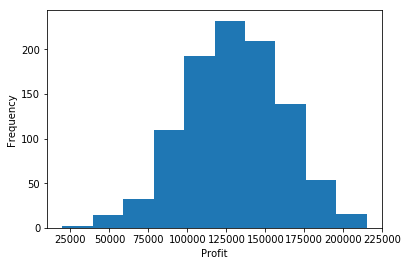

In [15]:
# Profit
profit = sales - costs
plt.hist(profit)
plt.xlabel('Profit')
plt.ylabel('Frequency');

In [16]:
# Profit Summary Statistics
pd.Series(profit).describe()

count      1000.000000
mean     129881.644850
std       31304.677502
min       19814.432634
25%      108924.224591
50%      129996.762145
75%      152008.968244
max      215122.019457
dtype: float64

Let's define a function that simulates the profit Mr. Diggs will earn for a given house size and number of replications.

In [17]:
def sim_profit(sqft=2500, N=1000, sflag=False):
    # Set random state
    if sflag:
        np.random.seed(12345)
    
    # Construction costs
    costs_sqft = np.random.triangular(left=135, mode=155, right=185, size=N)
    costs = sqft * costs_sqft
    
    # Time to sell
    months = range(1, 13)
    p = [0.16, 0.22, 0.18, 0.11, 0.08, 0.06, 0.05, 0.05, 0.03, 0.03, 0.02, 0.01]
    t = np.random.choice(a=months, p=p, size=N)
    
    # Initial asking price
    initial_asking_sqft = 280 - 0.02 * sqft
    initial_asking = sqft * initial_asking_sqft
    
    pct_reduction = 0.01 # per month
    initial_offer = initial_asking * (1 - t * pct_reduction)
    
    # Negotations
    pct_off_asking = np.random.triangular(left=0., mode=0.04, right=0.10, size=N)
    sales = initial_offer * (1 - pct_off_asking)
    
    # Profit
    profit = sales - costs
    
    return profit

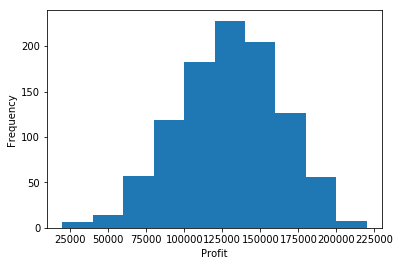

In [18]:
# Test function
profit = sim_profit()
plt.hist(profit)
plt.xlabel('Profit')
plt.ylabel('Frequency');

In [19]:
# Profit Summary Statistics
pd.Series(profit).describe()

count      1000.000000
mean     129295.618925
std       33341.581230
min       19980.381902
25%      107634.581816
50%      129981.967161
75%      152416.284298
max      219960.875600
dtype: float64

Now, let's use our function to perform sensitivity analysis on the size of the house to build:

In [20]:
sqfts = np.arange(2000,3100,100)
results = {sqft:sim_profit(sqft=sqft, sflag=True) for sqft in sqfts}

In [21]:
df = pd.DataFrame(results)
df.head()

,2000,2100,2200,2300,2400,2500,2600,2700,2800,2900,3000
0,81707.077590,82019.807241,81973.239347,81567.373907,80802.210922,79677.750391,78193.992315,76350.936693,74148.583526,71586.932813,68665.984554
1,129821.696566,132503.069942,134821.613655,136777.327707,138370.212097,139600.266824,140467.491889,140971.887292,141113.453033,140892.189112,140308.095529
2,124084.519653,126603.176916,128770.827634,130587.471808,132053.109437,133167.740522,133931.365062,134343.983057,134405.594507,134116.199413,133475.797774
3,91596.332903,92761.888637,93602.276664,94117.496986,94307.549601,94172.434511,93712.151715,92926.701213,91816.083005,90380.297091,88619.343472
4,103978.472262,105475.703267,106620.392119,107412.538818,107852.143363,107939.205756,107673.725995,107055.704081,106085.140014,104762.033794,103086.385421


In [22]:
# Summarize results for each size house
df.describe()

,2000,2100,2200,2300,2400,2500,2600,2700,2800,2900,3000
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,122574.960370,124857.882268,126774.535012,128324.918602,129509.033037,130326.878318,130778.454445,130863.761418,130582.799236,129935.567900,128922.067410
std,25830.212873,27040.777193,28244.066090,29440.142787,30629.071248,31810.916175,32985.743021,34153.617995,35314.608063,36468.780959,37616.205185
min,48528.304757,47518.854267,46182.178469,44518.277363,42527.150950,40208.799229,37563.222201,34590.419866,31290.392223,27587.742225,23516.216621
25%,104581.185983,106057.526766,107209.571008,107995.971233,108301.062392,108304.815367,107964.375328,107113.346847,106065.303515,104711.310954,103071.316566
50%,123666.076255,125955.303030,127993.278061,129636.332612,130921.254808,131811.911973,132257.026734,132264.842131,131994.442657,131246.326361,130157.573166
75%,142006.562105,145218.805090,148071.164493,150554.176462,152625.029923,154334.772656,155647.375351,156566.354313,157097.863051,157244.257350,157090.410649
max,183657.667316,188831.445743,193623.404652,198033.544043,202061.863916,205708.364271,208973.045108,211855.906427,214356.948228,216476.170511,218213.573276


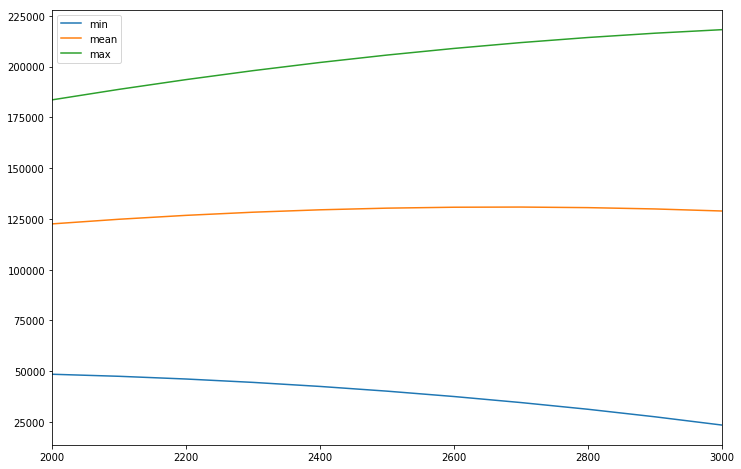

In [23]:
# Visualize results
df.describe().loc[['min','mean','max']].T.plot(kind='line', figsize=(12,8));

## Statistical Inference

As mentioned previously, statistical inference in Python is primarily facilitated by **scipy.stats**. Let's revisit our Lending Club sample data for this analysis.

In [24]:
# Load Lending Club data
# path = '/Users/seanbarnes/Dropbox/Teaching/Courses/BUDT758X/data/'
df = pd.read_csv('lendingclub_sample.csv')

# Select
df = df[['id','loan_amnt','term','int_rate']]

# Basic data processing - Remove % from int_rate variable, convert to float
df['int_rate'] = df['int_rate'].str.rstrip('%').astype(float)

# Preview data
df.head()

FileNotFoundError: [Errno 2] File b'/Users/seanbarnes/Dropbox/Teaching/Courses/BUDT758X/data/lendingclub_sample.csv' does not exist: b'/Users/seanbarnes/Dropbox/Teaching/Courses/BUDT758X/data/lendingclub_sample.csv'

Let's compute a 99% confidence interval estimate for the mean interest rate in the training data set. Unfortunately, similar to many other programming languages, there is not a built-in function to compute confidence intervals. We still need to rely on our statistical expertise!

$100(1-\alpha)\%$ Confidence Intervals for the Mean:

$\bar{X} \pm t_{n-1, 1-\alpha/2} \frac{s}{\sqrt{n}}$

We can determine the appropriate t-multiple using **ss.t.ppf** (percent point function). Similarly, for z-multiples (means with known variance or proportions), we can use **ss.norm.ppf**.

In [ ]:
# Compute 99% confidence interval for the mean interest rate
alpha = 0.01
n = len(df)
mean = df['int_rate'].mean()
s = df['int_rate'].std()
t = ss.t.ppf(1 - alpha / 2, df=n-1)
(mean - t * s / n ** 0.5, mean + t * s / n ** 0.5)

CreditCards.com reported in April 2015 that the national average annual percentage rate across all categories of credit cards was 14.90%. How does the mean interest rate for loans issued through Lending Club compare to this national average?

In [ ]:
# One-sample t-test
ss.ttest_1samp(a=df['int_rate'], popmean=14.90)

As we observed in our regression analysis, the term of the loan has a significant impact on the associated interest rate. Let's explore the impact of the loan term on the amount of money borrowed.

In [ ]:
# Visualize distribution of loan amounts as a function of term
df.boxplot(column='loan_amnt', by='term', flierprops={'marker': '.'}, figsize=(8,6))
plt.xlabel('')
plt.ylabel('Loan Amount (\$)')
plt.title('')
plt.suptitle('');

In [ ]:
# Evaluate equal variance assumption
df.groupby('term')['loan_amnt'].std()

In [ ]:
# Two-sample t-test
ss.ttest_ind(a=df['loan_amnt'][df['term'] == ' 36 months'], b=df['loan_amnt'][df['term'] == ' 60 months'], equal_var=False)

## Next Time: Project Showcase!!